In [92]:
!pip install geopandas
!pip install plotly --upgrade
!pip install mapclassify --upgrade

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
import seaborn as sns
import glob
import plotly
from datetime import datetime
import re
import geopandas
from matplotlib.colors import Normalize
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.pyplot import figure
from mapclassify import UserDefined
from google.colab import drive
%matplotlib inline
import statsmodels.formula.api as smf
drive.mount("/content/drive")

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (5.1.0)
Requirement already up-to-date: mapclassify in /usr/local/lib/python3.7/dist-packages (2.4.2)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Difference in Difference for New Orleans

First, we compare New Orleans to Nashville to evaluate whether the regulation affected overall rentals. Nashville could be perceived as a more traditionally-regulated city.

In [93]:
city_analysis = pd.read_csv("/content/drive/MyDrive/Work/Citadel 2021/Data/city_analysis.csv")
city_analysis = city_analysis.rename(columns = {"Unnamed: 0": "city"}).set_index("city")
city_analysis.drop(index = "Los Angeles", columns = ["August 2015", "September 2015"], inplace = True)
city_analysis.columns = pd.to_datetime(city_analysis.columns)
city_analysis

,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
New Orleans,2667,2941.0,3041.0,3319.0,3621.0,3857.0,4032.0,4301,4316.0,4360.0,4431,4456,4514,4660.0,4775,4820.0,5087.0,5433,5455,5652,5307,3665,3947.0,3766.0,4238.0,4412.0,4561.0,4759.0,5149.0,5215.0,5408.0,5587.0,NaN,5887.0,5878.0,5813.0,6066.0,6237.0,6508.0,6527.0,6690.0,6632.0,6721.0,6962.0,6949.0,7002.0,7046.0,7149.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6657,6350,6408,6404,6326,6179,6279,6294,6508.0,6173.0
Nashville,2110,NaN,NaN,NaN,NaN,NaN,NaN,3012,NaN,NaN,3486,3277,3603,NaN,4067,NaN,NaN,4077,4357,4463,4787,4804,NaN,5332.0,NaN,NaN,NaN,NaN,NaN,NaN,5201.0,5250.0,NaN,5446.0,5754.0,5779.0,5867.0,5921.0,5899.0,5998.0,6045.0,6180.0,6490.0,6855.0,6962.0,NaN,7200.0,7282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7129.0,6848.0,6681,6139,6091,6054,5945,6153,6112,6144,NaN,NaN


In [94]:
fig = go.Figure([go.Scatter(x = city_analysis.columns, y = city_analysis.iloc[0,:], mode = "lines+markers", 
                              connectgaps = True, name = "New Orleans"), 
                 go.Scatter(x = city_analysis.columns, y = city_analysis.iloc[1,:], mode = "lines+markers", 
                             connectgaps = True, name = "Nashville")])
fig.update_layout(autosize = False, width=1200, height=500, font_family="Times New Roman", font_size = 20)
#What we notice here is that the data are remarkably parallel, except for the trough from June 2017 to February 2018. This is a strong case for diff-diff

In [ ]:
#Interpolate data to prepare for Diff Diff Analysis (don't do this anymore, it is statistically wrong)
city_analysis.loc["New Orleans", :pd.to_datetime("September 1 2019")] = city_analysis.loc["New Orleans", :pd.to_datetime("September 1 2019")].interpolate(method = "linear", limit = 6)
city_analysis.loc["Nashville", :pd.to_datetime("September 1 2019")] = city_analysis.loc["Nashville", :pd.to_datetime("September 1 2019")].interpolate(method = "linear", limit = 6)
city_analysis.loc[:, :pd.to_datetime("September 1 2019")] = city_analysis.loc[:, :pd.to_datetime("September 1 2019")].astype(int)
city_analysis

In [ ]:
#y = b_0 + b_1 * NO_i + b_2 * May2_i + b_3 * NO_i + e_i

def diff_month(d1, d2): #https://stackoverflow.com/questions/4039879/best-way-to-find-the-months-between-two-dates
    return (d1.year - d2.year) * 12 + d1.month - d2.month


diff_analysis = pd.DataFrame(city_analysis.transpose()).reset_index().rename(columns = {"index": "date"})
diff_analysis["city"] = "New Orleans"
diff_analysis.drop(columns = "Nashville", inplace = True)
diff_analysis.rename(columns = {"New Orleans": "count"}, inplace = True)

diff_analysis2 = pd.DataFrame(city_analysis.transpose()).reset_index().rename(columns = {"index": "date"})
diff_analysis2["city"] = "Nashville"
diff_analysis2.drop(columns = "New Orleans", inplace = True)
diff_analysis2.rename(columns = {"Nashville": "count"}, inplace = True)
diff_analysis2

diff_analysis = diff_analysis.append(diff_analysis2)

diff_analysis["after_treatment"] = 1
diff_analysis["after_treatment"] = diff_analysis["after_treatment"].where((diff_analysis.date >= pd.to_datetime("June 1 2017")), 0)
diff_analysis["New_Orleans"] = 1
diff_analysis["New_Orleans"] = diff_analysis["New_Orleans"].where(diff_analysis.city == "New Orleans", 0)

diff_analysis

In [ ]:
print(smf.ols('count ~ after_treatment*New_Orleans', data=diff_analysis).fit().summary().tables[1])

In [ ]:
diff_analysis.to_csv("diff_analysis.csv")

In [ ]:
sns.scatterplot(x = diff_analysis.date, y = diff_analysis["count"])

#Synthetic Control Model for French Quarter

In [ ]:
neighborhoods = pd.read_csv("/content/drive/MyDrive/Work/Citadel 2021/Data/neighborhoods.csv")
neighborhoods = neighborhoods.set_index("neighborhood").drop(columns = "Unnamed: 0").loc[:,:"September 2019"]
neighborhoods

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))

top_5 = list(neighborhoods.loc[:, "August 2015" : "May 2017"].median(axis = 1).sort_values()[64:69].index)

neighborhoods.loc["french quarter", "August 2015":].plot(ax = ax, label = "French Quarter")
neighborhoods[neighborhoods.index.isin(top_5)].median()[1:].plot(ax = ax, label = "Top 5 Neighborhoods")
plt.xlabel("Date")
plt.ylabel("Listings")

plt.legend()

In [ ]:
top_10 = list(neighborhoods.loc[:, "August 2015" : "May 2017"].median(axis = 1).sort_values()[58:69].index)
top_10.remove("central business district")

"""#Cross-validation for SCM
scm_min_error = 999999999
min_scm_value = 0
cv_error = 0
error_SCM = []
for i in np.arange(1.0, 100, 1):

  def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - i,
                         bounds=[(0, np.sqrt(i))]*len(w_start),
                         disp=False)
    return weights

  for neighborhood in top_10:

    neighborhood_y = pd.DataFrame(neighborhoods.loc[neighborhood, "August 2015":"May 2017"]).values
    neighborhoods_x = neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood)].loc[:, "August 2015" : "May 2017"].transpose().dropna(axis = 1).values

    weights_scm = get_w(neighborhoods_x, neighborhood_y)
    neighborhood_synthetic = pd.DataFrame(neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood)].loc[:, "August 2015" : ].dropna(axis = 0)).transpose().values.dot(weights_scm)

    cv_error = np.sum(np.square(neighborhood_synthetic[22:] - neighborhoods.loc[neighborhood, "June 2017":])) + cv_error

  if cv_error < scm_min_error:
    scm_min_error = cv_error
    min_scm_value = i
    print(min_scm_value)

  print(cv_error)
  error_SCM.append(cv_error)
  cv_error = 0"""

In [ ]:
french_y = pd.DataFrame(neighborhoods.loc["french quarter", "August 2015":"May 2017"]).values
neighborhoods_x = neighborhoods[neighborhoods.index != "french quarter"].loc[:, "August 2015" : "May 2017"].transpose().dropna(axis = 1).values

from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp
from sklearn.linear_model import Ridge

def loss_w(W, X, y) -> float: #https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0, np.sqrt(1))]*len(w_start),
                         disp=False)
    return weights

french_weights = get_w(neighborhoods_x, french_y)
print("Sum:", french_weights.sum())

french_synthetic = pd.DataFrame(neighborhoods[neighborhoods.index != "french quarter"].loc[:, "August 2015" : ].dropna(axis = 0)).transpose().values.dot(french_weights)

fig, ax = plt.subplots(1, 1, figsize = (12,6))

neighborhoods.loc["french quarter", "August 2015":].plot(ax = ax, label = "French Quarter")
plt.plot(neighborhoods.loc[:, "August 2015": ].columns, french_synthetic, label = "Synthetic Control")

plt.xlabel("Date")
plt.ylabel("Listings")

plt.legend()

In [ ]:
fig = go.Figure()
for neighborhood in neighborhoods.loc[top_10, :].index.unique():
  fig.add_trace(go.Scatter(x = pd.to_datetime(neighborhoods.columns[2:]), y = neighborhoods.loc[neighborhood, :][2:], 
                           name = neighborhood, mode = "lines+markers", ))


fig.add_trace(go.Scatter(x = pd.to_datetime(neighborhoods.columns[2:]), y = neighborhoods.loc["french quarter", :][2:], 
                           name = "french quarter", mode = "lines+markers", line_color = "black"))

fig.add_shape(type="rect", x0 = pd.to_datetime("March 2017"), x1 = pd.to_datetime("July 2017"), y0 = 0, y1 = 1300, 
              line = dict(color = "LightSkyBlue"), fillcolor = "LightSkyBlue", opacity = 0.3)
fig.update_xaxes(title = "Date")
fig.update_layout(autosize = False, width=1200, height=500, font_family="Times New Roman", font_size = 20
)

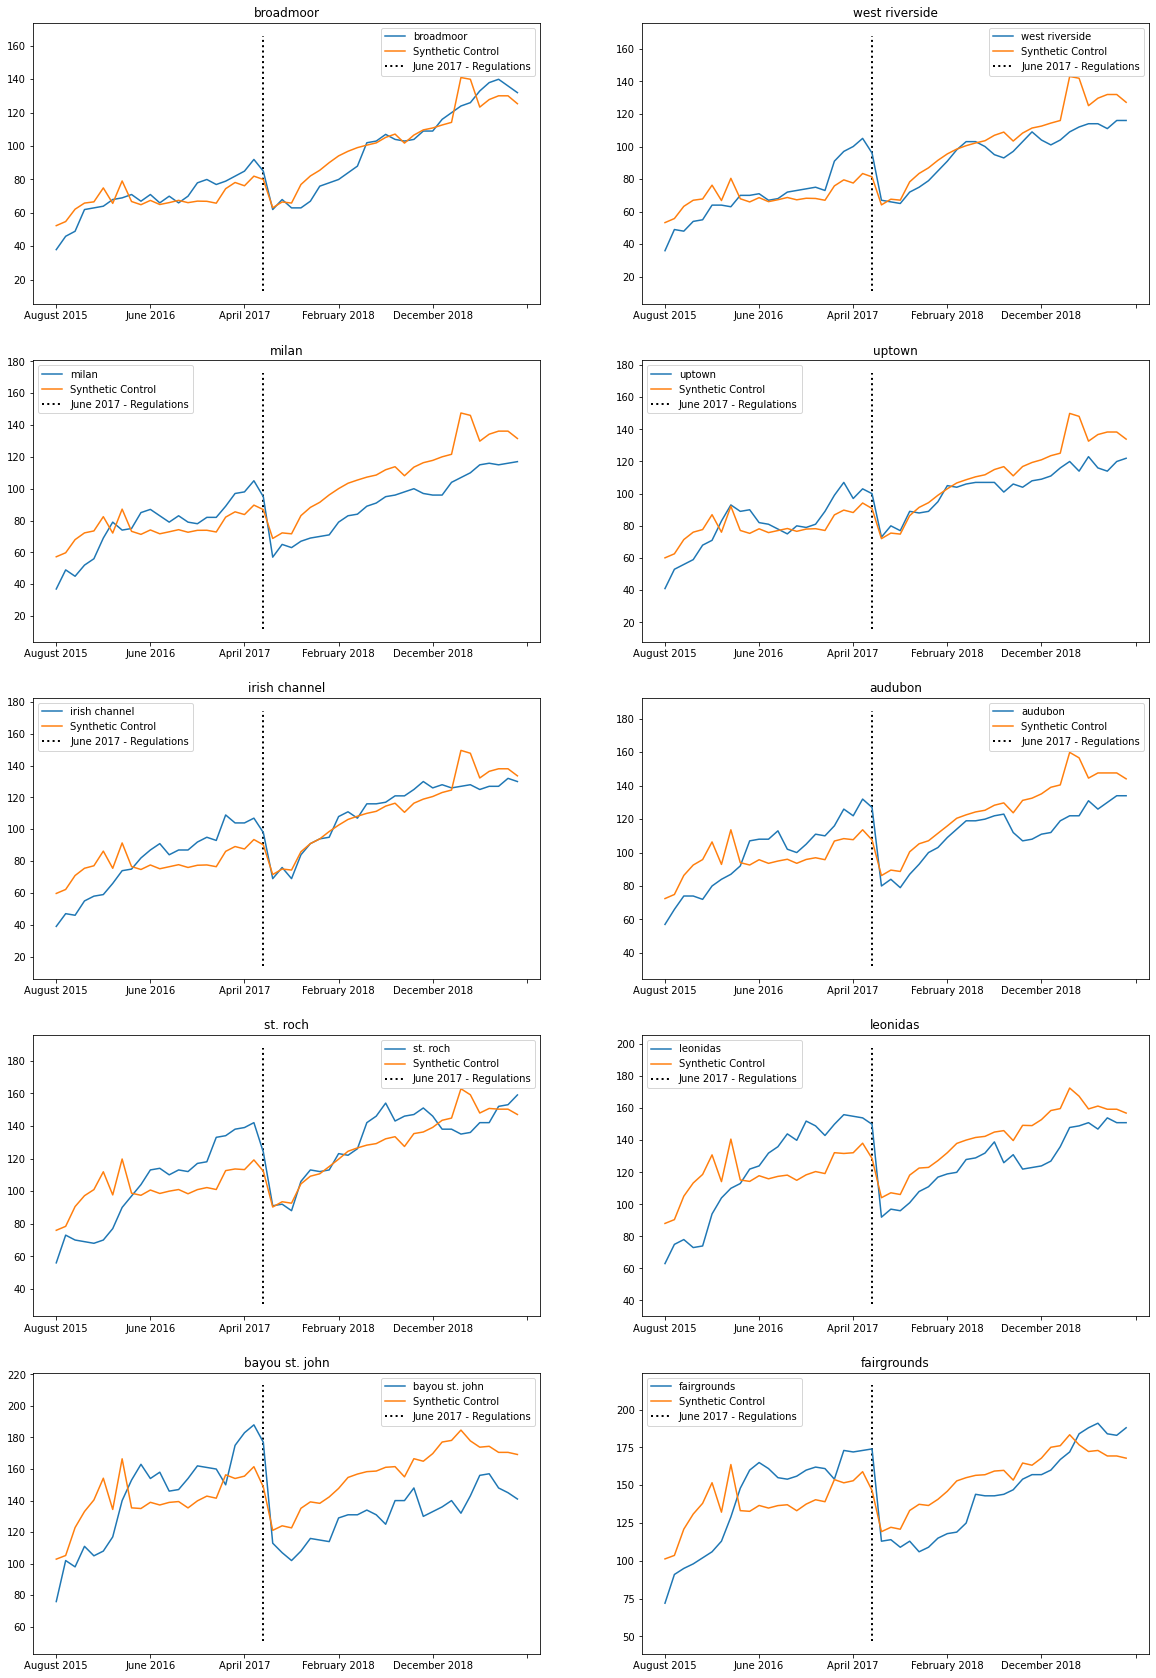

In [ ]:
top_10 = list(neighborhoods.loc[:, "August 2015" : "May 2017"].median(axis = 1).sort_values()[50:60].index)

fig, axes = plt.subplots(5,2, figsize= (20,30))

axeslist = axes.flatten()
i = 0
for neighborhood in top_10:


  neighborhood_y = pd.DataFrame(neighborhoods.loc[neighborhood, "August 2015": "May 2017"]).values
  neighborhoods_x = neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood)].loc[:, "August 2015" : "May 2017"].transpose().dropna(axis = 1).values

  weights_scm = get_w(neighborhoods_x, neighborhood_y)
  neighborhood_synthetic = pd.DataFrame(neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood) 
                                  ].loc[:, "August 2015" : ].dropna(axis = 0)).transpose().values.dot(weights_scm)

  neighborhoods.loc[neighborhood, "August 2015":].plot(ax = axeslist[i], label = neighborhood)
  axeslist[i].plot(neighborhoods.loc[:, "August 2015": ].columns, neighborhood_synthetic, label = "Synthetic Control")
  axeslist[i].vlines(x="June 2017", ymin=min(neighborhoods.loc[neighborhood, "August 2015":].min(), neighborhood_synthetic.min()) - 25, 
             ymax=max(neighborhoods.loc[neighborhood, "August 2015":].max(), neighborhood_synthetic.max()) + 25, linestyle=":", lw=2, label="June 2017 - Regulations")

  axeslist[i].set_title(neighborhood)
  axeslist[i].legend()
  i = i + 1


TypeError: ignored

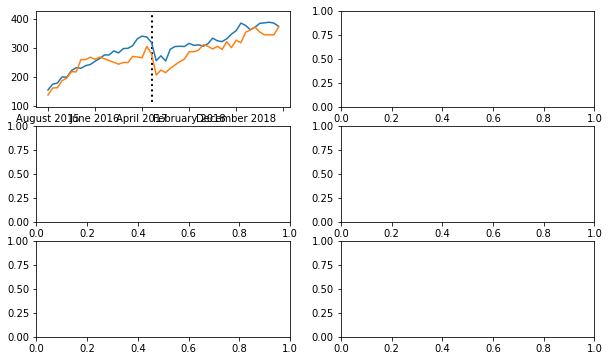

In [ ]:
nearby_neighborhoods = ["marigny", "seventh ward", "treme - lafitte",  "central business district", "st. claude"]

fig, axes = plt.subplots(3, 2, figsize= (10,6))
ax = axes.flatten()
i = 0
for neighborhood in nearby_neighborhoods:


  neighborhood_y = pd.DataFrame(neighborhoods.loc[neighborhood, "August 2015":"May 2017"]).values
  neighborhoods_x = neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood) & (~neighborhoods.index.isin(nearby_neighborhoods))].loc[:, "August 2015" : "May 2017"].transpose().dropna(axis = 1).values

  weights_scm = get_w(neighborhoods_x, neighborhood_y)
  neighborhood_synthetic = pd.DataFrame(neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood) 
                                  & (~neighborhoods.index.isin(nearby_neighborhoods))].loc[:, "August 2015" : ].dropna(axis = 0)).transpose().values.dot(weights_scm)

  neighborhoods.loc[neighborhood, "August 2015":].plot(ax = ax[i], label = neighborhood)
  ax[i].plot(neighborhoods.loc[:, "August 2015": ].columns, neighborhood_synthetic, label = "Synthetic Control")
  ax[i].vlines(x="June 2017", ymin=min(neighborhoods.loc[neighborhood, "August 2015":].min(), neighborhood_synthetic.min()) - 25, 
             ymax=max(neighborhoods.loc[neighborhood, "August 2015":].max(), neighborhood_synthetic.max()) + 25, linestyle=":", lw=2, label="June 2017 - Regulations")

  ax[i].title(neighborhood)
  ax[i].legend()
  i + 1


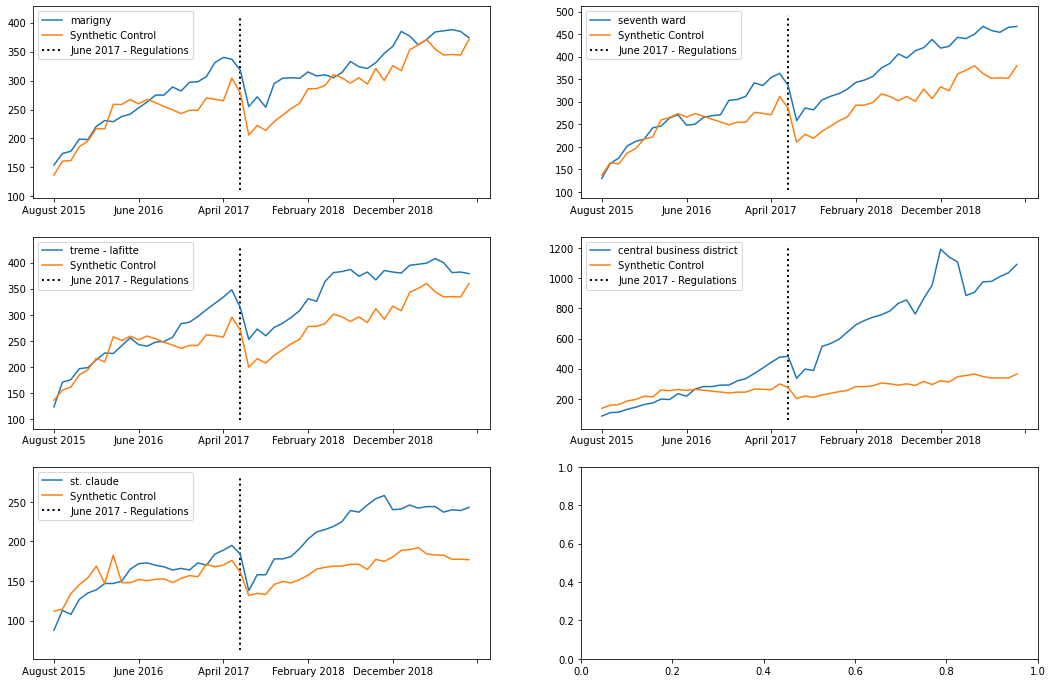

In [ ]:
nearby_neighborhoods = ["marigny", "seventh ward", "treme - lafitte",  "central business district", "st. claude"]

fig, axes = plt.subplots(3, 2, figsize= (18,12))
ax = axes.flatten()
i = 0
for neighborhood in nearby_neighborhoods:


  neighborhood_y = pd.DataFrame(neighborhoods.loc[neighborhood, "August 2015":"May 2017"]).values
  neighborhoods_x = neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood) & (~neighborhoods.index.isin(nearby_neighborhoods))].loc[:, "August 2015" : "May 2017"].transpose().dropna(axis = 1).values

  weights_scm = get_w(neighborhoods_x, neighborhood_y)
  neighborhood_synthetic = pd.DataFrame(neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood) 
                                  & (~neighborhoods.index.isin(nearby_neighborhoods))].loc[:, "August 2015" : ].dropna(axis = 0)).transpose().values.dot(weights_scm)

  neighborhoods.loc[neighborhood, "August 2015":].plot(ax = ax[i], label = neighborhood)
  ax[i].plot(neighborhoods.loc[:, "August 2015": ].columns, neighborhood_synthetic, label = "Synthetic Control")
  ax[i].vlines(x="June 2017", ymin=min(neighborhoods.loc[neighborhood, "August 2015":].min(), neighborhood_synthetic.min()) - 25, 
             ymax=max(neighborhoods.loc[neighborhood, "August 2015":].max(), neighborhood_synthetic.max()) + 25, linestyle=":", lw=2, label="June 2017 - Regulations")

  ax[i].legend()
  i = i+ 1


In [ ]:
top_30 = list(neighborhoods.loc[:, "August 2015" : "May 2017"].median(axis = 1).sort_values()[39:69].index)

neighborhoods_other_synthetic = []
for neighborhood in top_30:


  neighborhood_y = pd.DataFrame(neighborhoods.loc[neighborhood, "August 2015": "May 2017"]).values
  neighborhoods_x = neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood)].loc[:, "August 2015" : "May 2017"].transpose().dropna(axis = 1).values

  weights_scm = get_w(neighborhoods_x, neighborhood_y)
  neighborhood_synthetic = pd.DataFrame(neighborhoods[(neighborhoods.index != "french quarter") & (neighborhoods.index != neighborhood) 
                                  ].loc[:, "August 2015" : ].dropna(axis = 0)).transpose().values.dot(weights_scm)
  
  neighborhoods_other_synthetic.append(list(neighborhood_synthetic))

synthetics = pd.DataFrame(neighborhoods_other_synthetic, columns = neighborhoods.columns[2:])
synthetics.index = top_30
synthetics

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
for synthetic in synthetics.index:
    plt.plot(neighborhoods.columns[2:], neighborhoods.loc[synthetic, "August 2015":] - synthetics.loc[synthetic, :], color="C5",alpha=0.4)

plt.plot(neighborhoods.columns[2:], neighborhoods.loc["french quarter", "August 2015":] - french_synthetic,
        label="french quarter");

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 6 != 0:
        label.set_visible(False)


plt.vlines(x="June 2017", ymin = -300, ymax = 800, linestyle=":", lw=2, label="June 2017 - Regulations", color = "red")

ax.set_title("Neighborhoods: Actual Listings - Synthetic Control Listings")
plt.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
for synthetic in synthetics.index:
  if synthetic in nearby_neighborhoods:
    plt.plot(neighborhoods.columns[2:], neighborhoods.loc[synthetic, "August 2015":] - synthetics.loc[synthetic, :], label = synthetic)
  else:
    plt.plot(neighborhoods.columns[2:], neighborhoods.loc[synthetic, "August 2015":] - synthetics.loc[synthetic, :], color="C5",alpha=0.4)


for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 6 != 0:
        label.set_visible(False)


plt.vlines(x="June 2017", ymin = -300, ymax = 900, linestyle=":", lw=2, label="June 2017 - Regulations", color = "red")

ax.set_title("Formula: Actual Listings - Synthetic Control Listings")
plt.legend();

In [ ]:
effects = (neighborhoods.loc[synthetics.index, :].iloc[:, 2:] - synthetics) / neighborhoods.loc[synthetics.index, :].iloc[:, 2:]
for j in nearby_neighborhoods:
  print(j + ": " + str(np.mean(np.array(effects[effects.index != j].loc[:, "September 2019"]) >= effects.loc[j, "September 2019"])))

In [ ]:
neighborhoods["geometry"] = geopandas.GeoSeries.from_wkt(neighborhoods['geometry'])
neighborhoods["geometry"]

In [ ]:
effects["dist_french_quarter"] = geopandas.GeoSeries(neighborhoods["geometry"]).distance(neighborhoods[neighborhoods.index == "french quarter"]["geometry"].iloc[0])
effects["dist_french_quarter"]

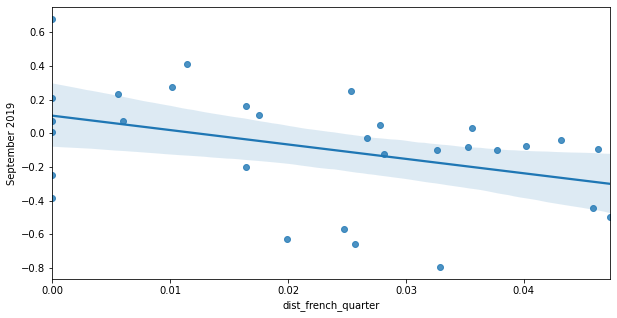

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x = effects["dist_french_quarter"], y = effects["September 2019"])

#Zipcodes and Price Analysis

In [ ]:
real_estate = pd.read_csv("/content/drive/MyDrive/Datasets/real_estate.csv.gz")
econ_state = pd.read_csv("/content/drive/MyDrive/Datasets/econ_state.csv")
demographics = pd.read_csv("/content/drive/MyDrive/Datasets/demographics.csv")
zipcodes = pd.read_csv("/content/drive/MyDrive/Work/Citadel 2021/Data/listings_zipcodes.csv")
zip_analysis = pd.read_csv("/content/drive/MyDrive/Work/Citadel 2021/Data/zip_analysis.csv").drop(columns = "Unnamed: 0")


In [ ]:
real_estate = real_estate.melt(id_vars = ["type",	"zipcode", "city", "state", "metro",	"county",	"size_rank"], var_name = "date", value_name = "rent")
real_estate.date = pd.to_datetime(real_estate["date"])
real_estate = real_estate[(real_estate.zipcode > 70000) & (real_estate.zipcode < 80000)]
real_estate[real_estate.zipcode == 70116]

In [ ]:
real_estate["date"] = real_estate["date"].astype(str)
zip_analysis["date"] = zip_analysis["date"].astype(str)

neworleans_zips = zip_analysis[zip_analysis.zipcode > 70000].merge(real_estate, how = "left", on = ["zipcode", "date"])
neworleans_zips.date = pd.to_datetime(neworleans_zips.date)
neworleans_zips.sort_values(by = ["zipcode", "date"])
neworleans_zips.dropna(subset = ["rent"], inplace = True)
neworleans_zips

In [ ]:
fig = go.Figure()
for zip in neworleans_zips[neworleans_zips["zipcode"] > 70000]["zipcode"].unique():
  fig.add_trace(go.Scatter(x = neworleans_zips[neworleans_zips["zipcode"] == zip]["date"], 
                           y = neworleans_zips[neworleans_zips["zipcode"] == zip]["rent"], name = str(zip), mode = "lines+markers"))

fig.update_layout(title = "New Orleans Airbnb Bookings by Zipcode")
fig.update_xaxes(title = "Date")